# Tip Prediction with PySpark using Linear Regression

In this project, we'll walk through using PySpark to solve a regression problem. Specifically, we'll develop a linear model to estimate tip values based on features that are continuous, categorical, and string-based.

This project will be utilizing Spark's ML library, which is designed to be used with DataFrame structures and utilizes pipelines to make things efficient and concise. 

Let's import some stuff first

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorSlicer

import matplotlib.pyplot as plt
%matplotlib inline

#the following lines allow the notebook to have multiple outputs for a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Next, let's load the data. Note that I'm using PySpark with the databricks package to load csv data directly to a DataFrame. You should load the notebook with the following command:  
PYSPARK_DRIVER_PYTHON=ipython PYSPARK_DRIVER_PYTHON_OPTS="notebook" $SPARK_HOME/bin/pyspark --packages com.databricks:spark-csv_2.10:1.3.0  

We'll also split the data into test/train and validation sets.

In [2]:
#load data as dataframe
data = sqlContext.read.load('tips.csv', format='com.databricks.spark.csv', header='true', inferSchema='true')

#display the structure
data.printSchema()

#the column "tip" is the output, so rename it to "label"
#this is the default name for the label column for the linear regression model
#so i'll just stick with naming conventions here
data = data.withColumnRenamed('tip', 'label')

#note that the "size" column is of type integer. change this to double to avoid
#weird results later on
data = data.withColumn('size', data['size'].cast(DoubleType()))
data.printSchema()
                   
#randomly split the data into a test/train set and validation set (80%/20%)
splits = data.randomSplit([0.8, 0.2])
data_train = splits[0]
data_val = splits[1]

#take a look at some data
data.limit(5).toPandas()

root
 |-- total_bill: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: integer (nullable = true)

root
 |-- total_bill: double (nullable = true)
 |-- label: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: double (nullable = true)



,total_bill,label,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,Male,No,Sun,Dinner,3.0
2,21.01,3.50,Male,No,Sun,Dinner,3.0
3,23.68,3.31,Male,No,Sun,Dinner,2.0
4,24.59,3.61,Female,No,Sun,Dinner,4.0


Now we have to deal with our string and categorical features. Use StringIndexer to convert string-based categorical features to a numeric form, and use OneHotEncoder to convert numeric-based categorical features to one-hot encoded values. Note that we only have to do one-hot encoding for cases when the categorical feature has more than two possible states. Otherwise just doing a stringIndexer is good enough.

In [3]:
#convert sex --> sex_numeric. no one-hot encoding required because this can only have 
#two values (male or female)
stringIndexerSex = StringIndexer(inputCol='sex', outputCol='sex_numeric')

#convert smoker --> smoker_numeric. again, no one-hot encoding required because this can 
#only have two values (yes or no)
stringIndexerSmoker = StringIndexer(inputCol='smoker', outputCol='smoker_numeric')

#convert day --> day_numeric. also do one-hot encoding because there are mulitple possible values for day
#ie, monday gets mapped to the integer 0, and tuesday=1, wed=2, etc.
#then do one-hot encoding
stringIndexerDay = StringIndexer(inputCol='day', outputCol='day_numeric')
encoderDay = OneHotEncoder(inputCol='day_numeric', outputCol='day_vector')

#convert time --> time_numeric. no one-hot encoding required because this can only have 
#two values (lunch or dinner)
stringIndexerTime = StringIndexer(inputCol='time', outputCol='time_numeric')

The remaining variables "total_bill" and "size" are continuous variables. Well, kind of...one could argue that "size" is a categorical value. But I'll be treating it as continuous, because spark gave better results with "size" as continuous rather than categorical. We need to normalize both features to mean=0, standard deviation=1 before training the linear regression model. Conveniently, there is a function to do that using spark. First, combine all continuous variables into a single vector using VectorAssembler. Then pass to StandardScaler to do column-wise normalization (the output will be another vector).

In [4]:
assemblerScaler = VectorAssembler(inputCols=['size', 'total_bill'], outputCol='cont_feats')
scaler = StandardScaler(inputCol='cont_feats', outputCol='cont_feats_scaled', withStd=True, withMean=True)

Lastly combine all the features (both one-hot encoded features and continuous, normalized features) into one big vector for input to the linear regression model. Call this vector "features", as the default name for the features vector for linear regression is "features". Again, we'll stick with the naming conventions to keep things more clear.  

Note that there are eight features in total. Gender, smoking preference, and time are all categorical variables with two possible values, and so they each are represented by a single column. Day is categorical variable with 4 possible values, so one-hot encoding results in 3 possible values. There are also two continuous features, size and total bill.

In [5]:
all_feats = ['sex_numeric', 'smoker_numeric', 'day_vector', 'time_numeric', 'cont_feats_scaled']
assemblerAllFeatures = VectorAssembler(inputCols=all_feats, outputCol='features')

Now we can conveniently put all the above steps together into a pipeline for intput into the linear regression model! For now, lets test the pipeline to see that the output is what we expected.

In [6]:
#define the pipeline
pipeline = Pipeline(stages=[stringIndexerSex, stringIndexerSmoker, stringIndexerDay, encoderDay, \
                            stringIndexerTime, assemblerScaler, scaler, assemblerAllFeatures])
#fit the pipeline on the training data. what it means to "fit" the pipeline is to basically go through each of the 
#stages of the piepline and figure out the appropriate parameters. for example, in the stringIndexerSex stage, it 
#may decide to define Female=1 and Male=0 (or vice versa)
pipelineModel = pipeline.fit(data_train)

#actually transform the data now that the pipeline is fit. note that the resultant features vector may be sparse
output = pipelineModel.transform(data_train)

#take a look at the output
output.limit(3).toPandas()

,total_bill,label,sex,smoker,day,time,size,sex_numeric,smoker_numeric,day_numeric,day_vector,time_numeric,cont_feats,cont_feats_scaled,features
0,3.07,1.0,Female,Yes,Sat,Dinner,1.0,1.0,1.0,0.0,"(1.0, 0.0, 0.0)",0.0,"[1.0, 3.07]","[-1.62069996297, -1.88705084441]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -1.62069996297,..."
1,5.75,1.0,Female,Yes,Fri,Dinner,2.0,1.0,1.0,3.0,"(0.0, 0.0, 0.0)",0.0,"[2.0, 5.75]","[-0.54207712072, -1.57079345366]","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.54207712072,..."
2,7.25,1.0,Female,No,Sat,Dinner,1.0,1.0,0.0,0.0,"(1.0, 0.0, 0.0)",0.0,"[1.0, 7.25]","[-1.62069996297, -1.39378372003]","(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.62069996297,..."


It's generally a good idea to take a look at the correlations between input features. This is a good first step at feature selection, in which we can remove any highly correlated (and therefore redundant) features. Correlation analysis can only be done with continuous variables, of which we only have two (total bill and size).

The only tricky part of this section is extracting out the two continuous features from the features vector. To do so, define the function "dosplit" that will take each features vector, convert it to a list, grab the last two values of the list, and then return them as two columns. 

preview of continuous features DF:


,size_scaled,total_bill_scaled
0,-1.620700,-1.887051
1,-0.542077,-1.570793
2,-1.620700,-1.393784


correlation matrix:


,size_scaled,total_bill_scaled
size_scaled,1.000000,0.556958
total_bill_scaled,0.556958,1.000000


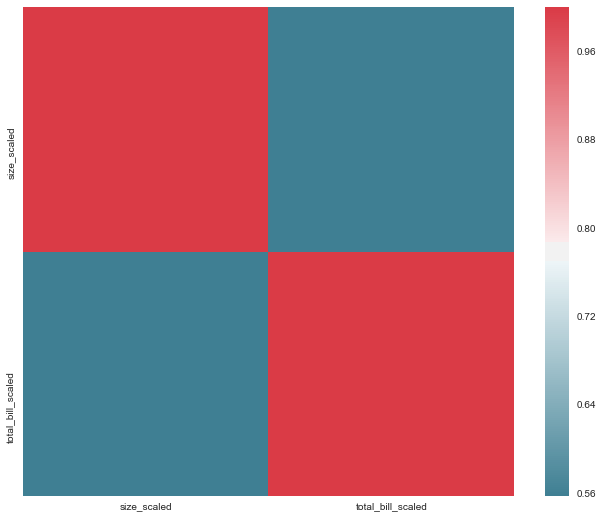

In [7]:
#define a function that will take the sparse vector corresponding to the "features" column
#and break it up into separate columns. then grab the last two columns and return those
def dosplit(row):
    return row[0].toArray().tolist()[-2:]

#grab the "features" column and split it into a dataframe of separate columns. to do this,
#first use an RRD mapping function. then convert the returned RDD result back into a dataframe.
#this DF-->RDD-->DF process is required since we are returning more than one column, which a UDF
#is not able to do
cont_feats = output.select('features')
cont_feats = cont_feats.rdd.map(dosplit).toDF(['size_scaled', 'total_bill_scaled'])
print 'preview of continuous features DF:'
cont_feats.limit(3).toPandas()

#compute the correlation matrix
cont_feats = cont_feats.toPandas()
corr = cont_feats.corr()
print 'correlation matrix:'
corr

#plot the correlation matrix as a heatmap 
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, ax=ax)
plt.show()

As it turns out, total bill and size are somewhat correlated. But the correlation isn't incredibly high, and we don't have many continuous features to work with, so let's keep both features for now.  

Now, it's time to develop a linear regression model. There are two paramters that will need to be determined via cross validation: elasticNetParam (determines the weight of the L1 vs L2 penalty) and regParam (the regularization parameter). So we'll leave those undefined for now. Furthermore, our pipeline output already matches the default input column name and features column name, so we don't have to specify those. We define standardization to be false, since we took care of that ourselves with the StandardScaler. Lastly, limit the number of iterations of SGD to 15 just to keep things from taking too long.

In [8]:
model = LinearRegression(standardization=False, maxIter=15)

#chain everything together into a pipeline
pipeline = Pipeline(stages=[stringIndexerSex, stringIndexerSmoker, stringIndexerDay, encoderDay, \
                            stringIndexerTime, assemblerScaler, scaler, assemblerAllFeatures, model])

#define a ParamGridBuilder to determine optimal values of elasticNetParam (range [0,1]) and regParam (typically 
#ranges between 0 and 1). we'll sweep through 0 to 1 in increments of 0.1 for both parameters
paramGrid = ParamGridBuilder().addGrid(model.elasticNetParam, np.array(range(0,11))/10.) \
                              .addGrid(model.regParam, np.array(range(0,11))/10.).build()

#define the RMSE to be the evaluation metric for model performance
evaluator = RegressionEvaluator(metricName='rmse')

#set up 3-fold cross validation to determine the optimal depth parameter (this can be set higher for potentially 
#better results)
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

#do the actual cross validation on the training data
CV_model = crossval.fit(data_train)

The CrossValidator iterated through every possible combination of elasticNetParam and regParam, developed a model for each combination of values, and evaluated each model's performance based on the RMSE. The best performing model was saved and can now be accessed from the CV_model object. Let's take a closer look at it.

In [9]:
#get the pipeine corresponding to the best model
best_model = CV_model.bestModel

#grab the last stage of the pipeline (the model)
print ('features: %s') % (['sex', 'smoker', 'day_1', 'day_2', 'day_3', 'time', 'size', 'total_bill'])
print ('feature weights: %s') % (best_model.stages[-1].coefficients)
trainingSummary = best_model.stages[-1].summary

#print out some of the model's properties
print ('numIterations: %d') % (trainingSummary.totalIterations)
print('RMSE: %f') % (trainingSummary.rootMeanSquaredError)
print('r2: %f') % (trainingSummary.r2)

features: ['sex', 'smoker', 'day_1', 'day_2', 'day_3', 'time', 'size', 'total_bill']
feature weights: [0.0,0.103632849468,-0.0778953142103,0.0,0.0,0.0,0.20978543848,0.611321703809]
numIterations: 10
RMSE: 0.962601
r2: 0.439849


The training converged after 10 iterations. Each of the eight features and their corresponding weights is listed above. Surprisingly, no weight was given to most of the categorical features. However, the total bill feature was highly weighted, which is an intuitive result.  

To understand if these results are reasonable, I ran the same linear regression analysis in scikit learn with 5 fold cross validation. Here are the results I obtained:

In [10]:
sklearn_coeffs = [0.04448793, -0.29463104, 0.09389824, 0.14555511, -0.21086302, 0.31639053, 0.11035866, 0.90419216]
sklearn_feats = ['sex', 'smoker', 'day_1', 'day_2', 'day_3', 'time', 'size', 'total_bill']
sklearn_RMSE = 1.063
sklearn_R2 = 0.358

print ('sklearn features: %s') % (sklearn_feats)
print ('sklearn feature weights: %s') % (sklearn_coeffs)
print('sklearn RMSE: %f') % (sklearn_RMSE)
print('sklearn r2: %f') % (sklearn_R2)

sklearn features: ['sex', 'smoker', 'day_1', 'day_2', 'day_3', 'time', 'size', 'total_bill']
sklearn feature weights: [0.04448793, -0.29463104, 0.09389824, 0.14555511, -0.21086302, 0.31639053, 0.11035866, 0.90419216]
sklearn RMSE: 1.063000
sklearn r2: 0.358000


While scikit did put nonzero weights on all the categorical features, it's clear that total bill is still heavily weighted in comparison to the remaining features. Furthermore, scikit's RMSE is almost identical, and the r2 is actually worse. So it seems that Spark's results are actually better.  

Either way, the r2 value is low in both cases and indicates that linear regression may not be the best model to fit this data. To find out what the best model might be, it would be necessary to do some data visualization (for example, plotting each input feature versus the tip). Let's just continue working with this model as it is.  

Now that we have a model, let's try applying it to our validation data to make sure it's behavior is consistent. We can directly apply our cross validation model to the validation data to obtain predictions (recall that it has saved the best model pipeline).

In [11]:
data_val_transformed = CV_model.transform(data_val)
data_val_transformed.limit(3).toPandas()

#now use the evaluator to determine the RMSE on the validation data 
print ('%s for validation data: %f') % (evaluator.getMetricName(), evaluator.evaluate(data_val_transformed))

,total_bill,label,sex,smoker,day,time,size,sex_numeric,smoker_numeric,day_numeric,day_vector,time_numeric,cont_feats,cont_feats_scaled,features,prediction
0,8.35,1.50,Female,No,Thur,Lunch,2.0,1.0,0.0,2.0,"(0.0, 0.0, 1.0)",1.0,"[2.0, 8.35]","[-0.54207712072, -1.26397658203]","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, -0.54207712072,...",1.987965
1,11.59,1.50,Male,Yes,Sat,Dinner,2.0,0.0,1.0,0.0,"(1.0, 0.0, 0.0)",0.0,"[2.0, 11.59]","[-0.54207712072, -0.88163555739]","(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.54207712072,...",2.247436
2,11.61,3.39,Male,No,Sat,Dinner,2.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0)",0.0,"[2.0, 11.61]","[-0.54207712072, -0.879275427608]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -0.54207712072,...",2.145246


rmse for validation data: 1.235193


The results are fairly consistent with the training data, so this is good news. Whenver we get new data that we want to evaluate, we can now simply apply the CV_model to it and get the results. You can save the best model here and load it at any later time.

In [12]:
#note that the below save function creates a folder called "best_model_tip". if you call "save" again, you need
#to first delete that folder.
best_model.save('best_model_tip')
loaded_best_model = PipelineModel.load('best_model_tip')

Note that we get the same results from applying the loaded model to the validation data:

In [13]:
data_val_transformed_loaded = loaded_best_model.transform(data_val)
data_val_transformed_loaded.limit(3).toPandas()

,total_bill,label,sex,smoker,day,time,size,sex_numeric,smoker_numeric,day_numeric,day_vector,time_numeric,cont_feats,cont_feats_scaled,features,prediction
0,8.35,1.50,Female,No,Thur,Lunch,2.0,1.0,0.0,2.0,"(0.0, 0.0, 1.0)",1.0,"[2.0, 8.35]","[-0.54207712072, -1.26397658203]","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, -0.54207712072,...",1.987965
1,11.59,1.50,Male,Yes,Sat,Dinner,2.0,0.0,1.0,0.0,"(1.0, 0.0, 0.0)",0.0,"[2.0, 11.59]","[-0.54207712072, -0.88163555739]","(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.54207712072,...",2.247436
2,11.61,3.39,Male,No,Sat,Dinner,2.0,0.0,0.0,0.0,"(1.0, 0.0, 0.0)",0.0,"[2.0, 11.61]","[-0.54207712072, -0.879275427608]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -0.54207712072,...",2.145246
